In [1]:
# common
import os
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
import pydot
import graphviz
import keras
import datetime
# Data
from keras import backend as K


# Clear any logs from previous runs
!rm -rf ./logs/ 
!mkdir ./logs/

print(os.getcwd())

# Data Viz
import matplotlib.pyplot as plt

# Model   
from keras.models import Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Input
from keras.layers import MaxPool2D
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import Dense
# Callbacks 
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# %pip install tf_explain
# from tf_explain.core.grad_cam import GradCAM

from keras.metrics import MeanIoU


/kaggle/working


In [2]:
SIZE=128
# (0: Neoplastic cells, 1: Inflammatory, 2: Connective/Soft tissue cells, 3: Dead Cells, 4: Epithelial, 6: Background)

def load_image(image):
    return np.round(tf.image.resize(image/255.,(SIZE, SIZE)),4)

def load_images(images):
    images_new=np.zeros((len(images),SIZE,SIZE,3))
    for i in range (len(images)):
        images_new[i]=load_image(images[i])

    print(images_new.shape)
    images=images_new
    del images_new
    return images

def load_labels(labels):
    labels=np.array(pd.get_dummies(labels))
    return labels
    
def load_masks(masks):
    masks=masks[:,:,:,0]+masks[:,:,:,1]+masks[:,:,:,2]+masks[:,:,:,3]+masks[:,:,:,4]
    masks=masks[...,np.newaxis]

    masks_new=np.zeros((len(masks),SIZE,SIZE,1))
    for i in range (len(masks)):
        masks_new[i]=load_image(masks[i])

    print(masks_new.shape)
    masks=masks_new
    masks=tf.cast((masks>0), tf.float32)
    del masks_new
    return masks

def show_image(image, title=None, cmap='coolwarm', alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4,title=None):
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

<!-- # Loading fold 1 of PanNuke dataset -->

# **Loading 1st Dataset**

In [3]:
labels1 = np.load('../input/cancer-inst-segmentation-and-classification/Part 1/Images/types.npy')
labels_name=np.unique(labels1)
labels1 = load_labels(labels1)

In [4]:
images1 = np.load('../input/cancer-inst-segmentation-and-classification/Part 1/Images/images.npy')
images1 = load_images(images1)

(2656, 128, 128, 3)


In [5]:
masks1 = np.load('../input/cancer-inst-segmentation-and-classification/Part 1/Masks/masks.npy')

In [6]:
masks1 = load_masks(masks1)

(2656, 128, 128, 1)


# **Loading 2nd Dataset**

In [7]:
labels2 = np.load('../input/cancer-instance-segmentation-and-classification-2/Images/types.npy')
labels2 = load_labels(labels2)

In [8]:
images2 = np.load('../input/cancer-instance-segmentation-and-classification-2/Images/images.npy')
images2 = load_images(images2)

(2523, 128, 128, 3)


In [9]:
masks2 = np.load('../input/cancer-instance-segmentation-and-classification-2/Masks/masks.npy')

In [10]:
masks2 = load_masks(masks2)

(2523, 128, 128, 1)


# **Loading 3rd Dataset**

In [11]:
# labels3 = np.load('../input/cancer-instance-segmentation-and-classification-3/Images/types.npy')
# labels3 = load_labels(labels3)

In [12]:
# images3 = np.load('../input/cancer-instance-segmentation-and-classification-3/Images/images.npy')
# images3 = load_images(images3)

In [13]:
# masks3 = np.load('../input/cancer-instance-segmentation-and-classification-3/Masks/masks.npy')

In [14]:
# masks3 = load_masks(masks3)

In [15]:
# labels=np.append(labels1,labels2,labels3, axis=0)
# del labels1,labels2,labels2
# masks=np.append(masks1,masks2,masks3, axis=0)
# del masks1,masks2,masks3
# images=np.append(images1,images2,images3,axis=0)
# del images1,images2,images3

labels=np.append(labels1,labels2, axis=0)
del labels1,labels2
masks=np.append(masks1,masks2, axis=0)
del masks1,masks2
images=np.append(images1,images2,axis=0)
del images1,images2

print(labels.shape)
print(labels_name.shape)
print(images.shape)
print(masks.shape)
print(labels_name)


(5179, 19)
(19,)
(5179, 128, 128, 3)
(5179, 128, 128, 1)
['Adrenal_gland' 'Bile-duct' 'Bladder' 'Breast' 'Cervix' 'Colon'
 'Esophagus' 'HeadNeck' 'Kidney' 'Liver' 'Lung' 'Ovarian' 'Pancreatic'
 'Prostate' 'Skin' 'Stomach' 'Testis' 'Thyroid' 'Uterus']


In [16]:
MAX_LIM=175
labels_name[0]="Adrenal"
print("Old Size: ",len(images))
for i in range(len(labels_name)):
    print("For",labels_name[i],"\tSamples: ",len((masks[np.argmax(labels,axis=1)==i])),"\tScore:",np.sum(masks[np.argmax(labels,axis=1)==i])/len((masks[np.argmax(labels,axis=1)==i]))/128/128)

labels_name=labels_name[:18]
labels=labels[:,:18]
indexes=[]
labels_new=[]
images_new=[]
masks_new=[]

for i in range(len(labels_name)):
    idx=np.argmax(labels,axis=1)==i
    
    if(np.sum(idx)/MAX_LIM>0.75):
        indexes=np.append(indexes,i)
        if labels_new==[]:
            labels_new = labels[idx][:MAX_LIM]
            images_new = images[idx][:MAX_LIM]
            masks_new = masks[idx][:MAX_LIM]
        else: 
            labels_new = np.append(labels_new,labels[idx][:MAX_LIM],axis=0)
            images_new = np.append(images_new,images[idx][:MAX_LIM],axis=0)
            masks_new =  np.append(masks_new,  masks[idx][:MAX_LIM],axis=0)     


print(indexes)
indexes=indexes.astype('uint8')
labels_new=labels_new[:,indexes]
labels_name=labels_name[indexes]


print(labels_new.shape)
print(labels_name.shape)
print(images_new.shape)
print(masks_new.shape)
print(labels_name)


labels=labels_new
del labels_new
images=images_new
del images_new
masks=masks_new
del masks_new

print("\n\n")
print("New Size: ",len(images))
for i in range(len(labels_name)):
    print("For",labels_name[i],"\tSamples: ",len((masks[np.argmax(labels,axis=1)==i])),"\tScore:",np.sum(masks[np.argmax(labels,axis=1)==i])/len((masks[np.argmax(labels,axis=1)==i]))/128/128)
    

Old Size:  5179
For Adrenal 	Samples:  282 	Score: 0.1385924427221853
For Bile-duct 	Samples:  262 	Score: 0.15442663294668416
For Bladder 	Samples:  82 	Score: 0.15391354444550304
For Breast 	Samples:  1576 	Score: 0.1903568016090974
For Cervix 	Samples:  207 	Score: 0.1964500537817029
For Colon 	Samples:  946 	Score: 0.18739096256441595
For Esophagus 	Samples:  283 	Score: 0.19312666498730124
For HeadNeck 	Samples:  239 	Score: 0.12502400545894352
For Kidney 	Samples:  93 	Score: 0.15076930548555106
For Liver 	Samples:  131 	Score: 0.15232418147662213
For Lung 	Samples:  133 	Score: 0.21274285567434212
For Ovarian 	Samples:  94 	Score: 0.2612492987450133
For Pancreatic 	Samples:  167 	Score: 0.15023968176927396
For Prostate 	Samples:  114 	Score: 0.17560296309621712
For Skin 	Samples:  146 	Score: 0.2376525042808219
For Stomach 	Samples:  98 	Score: 0.22561707788584184
For Testis 	Samples:  139 	Score: 0.17847426160633992
For Thyroid 	Samples:  164 	Score: 0.17179349573647104
For Ute

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


[ 0.  1.  3.  4.  5.  6.  7. 10. 12. 14. 16. 17.]
(1974, 12)
(12,)
(1974, 128, 128, 3)
(1974, 128, 128, 1)
['Adrenal' 'Bile-duct' 'Breast' 'Cervix' 'Colon' 'Esophagus' 'HeadNeck'
 'Lung' 'Pancreatic' 'Skin' 'Testis' 'Thyroid']



New Size:  1974
For Adrenal 	Samples:  175 	Score: 0.15842424665178573
For Bile-duct 	Samples:  175 	Score: 0.157314453125
For Breast 	Samples:  175 	Score: 0.1795619419642857
For Cervix 	Samples:  175 	Score: 0.19273890904017857
For Colon 	Samples:  175 	Score: 0.18832066127232142
For Esophagus 	Samples:  175 	Score: 0.20390311104910713
For HeadNeck 	Samples:  175 	Score: 0.10615059988839286
For Lung 	Samples:  133 	Score: 0.21274285567434212
For Pancreatic 	Samples:  167 	Score: 0.15023968176927396
For Skin 	Samples:  146 	Score: 0.2376525042808219
For Testis 	Samples:  139 	Score: 0.17847426160633992
For Thyroid 	Samples:  164 	Score: 0.17179349573647104


In [17]:
# MAX_LIM=175
# labels_name[0]="Adrenal"
# print("Old Size: ",len(images))
# for i in range(len(labels_name)):
#     print("For",labels_name[i],"\tSamples: ",len((masks[np.argmax(labels,axis=1)==i])),"\tScore:",np.sum(masks[np.argmax(labels,axis=1)==i])/len((masks[np.argmax(labels,axis=1)==i]))/128/128)

# labels_name=labels_name[:18]
# labels=labels[:,:18]


# for i in range(len(labels_name)):
#     idx=np.argmax(labels,axis=1)==i
    
    
    
#     if i==0:
#         labels_new = labels[idx][:MAX_LIM]
#         images_new = images[idx][:MAX_LIM]
#         masks_new = masks[idx][:MAX_LIM]
#     else: 
#         labels_new = np.append(labels_new,labels[idx][:MAX_LIM],axis=0)
#         images_new = np.append(images_new,images[idx][:MAX_LIM],axis=0)
#         masks_new =  np.append(masks_new,  masks[idx][:MAX_LIM],axis=0)     

# labels=labels_new
# del labels_new
# images=images_new
# del images_new
# masks=masks_new
# del masks_new

# print("\n\n")
# print("New Size: ",len(images))
# for i in range(len(labels_name)):
#     print("For",labels_name[i],"\tSamples: ",len((masks[np.argmax(labels,axis=1)==i])),"\tScore:",np.sum(masks[np.argmax(labels,axis=1)==i])/len((masks[np.argmax(labels,axis=1)==i]))/128/128)
    
# print(labels.shape)
# print(labels_name.shape)
# print(images.shape)
# print(masks.shape)
# print(labels_name)


In [18]:
idx= list(range(len(masks)))
np.random.shuffle(idx)
images=images[idx]
masks=masks[idx]
labels=labels[idx]

print(labels.shape)
print(labels_name.shape)
print(images.shape)
print(masks.shape)
print(labels_name)

(1974, 12)
(12,)
(1974, 128, 128, 3)
(1974, 128, 128, 1)
['Adrenal' 'Bile-duct' 'Breast' 'Cervix' 'Colon' 'Esophagus' 'HeadNeck'
 'Lung' 'Pancreatic' 'Skin' 'Testis' 'Thyroid']


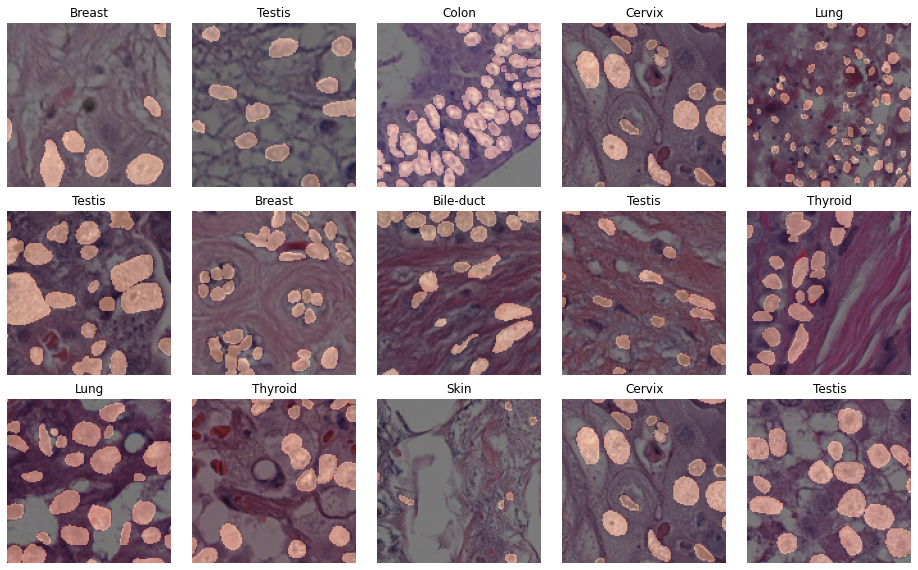

In [19]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='copper',title=labels_name[np.argmax(labels[id])],alpha=0.5) # binary afmhot copper

plt.tight_layout()
plt.show()

# **Encoder**

In [20]:
class EncoderBlock(Layer):

    def __init__(self, filters, rate, pooling=True, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate
        self.pooling = pooling

        self.c1 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.c2 = Conv2D(filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')
        self.pool = MaxPool2D()

    def call(self, X):
        x = self.c1(X)
        x = self.c2(x)
        if self.pooling:
            y = self.pool(x)
            return y, x
        else:
            return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
            'pooling':self.pooling
        }

# **Decoder**

In [21]:
class DecoderBlock(Layer):

    def __init__(self, filters, rate, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        self.up = UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling=False)

    def call(self, X):
        X, skip_X = X
        x = self.up(X)
        c_ = concatenate([x, skip_X])
        x = self.net(c_)
        return x

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            'rate':self.rate,
        }

# **Attention Gate**

In [22]:
class AttentionGate(Layer):

    def __init__(self, filters, bn, **kwargs):
        super(AttentionGate, self).__init__(**kwargs)

        self.filters = filters
        self.bn = bn

        self.normal = Conv2D(filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
        self.down = Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu', kernel_initializer='he_normal')
        self.learn = Conv2D(1, kernel_size=1, padding='same', activation='sigmoid')
        self.resample = UpSampling2D()
        self.BN = BatchNormalization()

    def call(self, X):
        X, skip_X = X

        x = self.normal(X)
        skip = self.down(skip_X)
        x = Add()([x, skip])
        x = self.learn(x)
        x = self.resample(x)
        f = Multiply()([x, skip_X])
        if self.bn:
            return self.BN(f)
        else:
            return f
        # return f

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "filters":self.filters,
            "bn":self.bn
        }

# **Classifier**

In [23]:
class ClassifierConv(Layer):

    def __init__(self, filters, **kwargs):
        super(ClassifierConv, self).__init__(**kwargs)

        self.filters = filters
        self.conv2d1 = Conv2D(filters  , kernel_size=3, padding='same', activation='relu')
        self.maxpool1= MaxPool2D()
        self.conv2d2 = Conv2D(filters*2, kernel_size=3, padding='same', activation='relu')
        self.maxpool2= MaxPool2D()

    def call(self, x):
        x = self.conv2d1(x)
        x = self.conv2d2(x)
        x = self.maxpool2(x)
        return x

class ClassifierDense(Layer):

    def __init__(self, units, **kwargs):
        super(ClassifierDense, self).__init__(**kwargs)

        self.flatten= Flatten()
        self.dense1= Dense(units, activation='relu')
        self.dense2= Dense(units//2, activation='relu')
        

    def call(self, x):
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

# **Loss Functions**

In [24]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) +
                                           smooth)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg +
                                  (1 - alpha) * false_pos + smooth)


def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)


def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)


def jacard_coef_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    IoU=(intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)
    return -IoU


# **Custom Callback**

In [25]:
class ShowProgress(Callback):
    def on_epoch_end(self, epochs, logs=None):
        if (epochs+1)%5==0:
            id = np.random.randint(images_train.shape[0])
            image = images_train[id]
            mask = masks_train[id]
            pred_mask, pred_value = self.model.predict(image[np.newaxis,...])
    #         exp = GradCAM()
    #         cam = exp.explain(
    #             validation_data=(image[np.newaxis,...], mask),
    #             class_index=1,
    #             layer_name='Attention4',
    #             model=self.model
    #         )

            plt.figure(figsize=(5,2.5))

            plt.subplot(1,2,1)
            plt.title("Original Mask: "+decodings[labels_train[id]])
            show_mask(image, mask, cmap='copper')

            plt.subplot(1,2,2)
            plt.title("Predicted Mask: "+decodings[pred_value.argmax()])
            show_mask(image, pred_mask, cmap='copper')

    #         plt.subplot(1,3,3)
    #         show_image(cam,title="GradCAM")

            plt.tight_layout()
            plt.show()
            

# **Attention UNet**

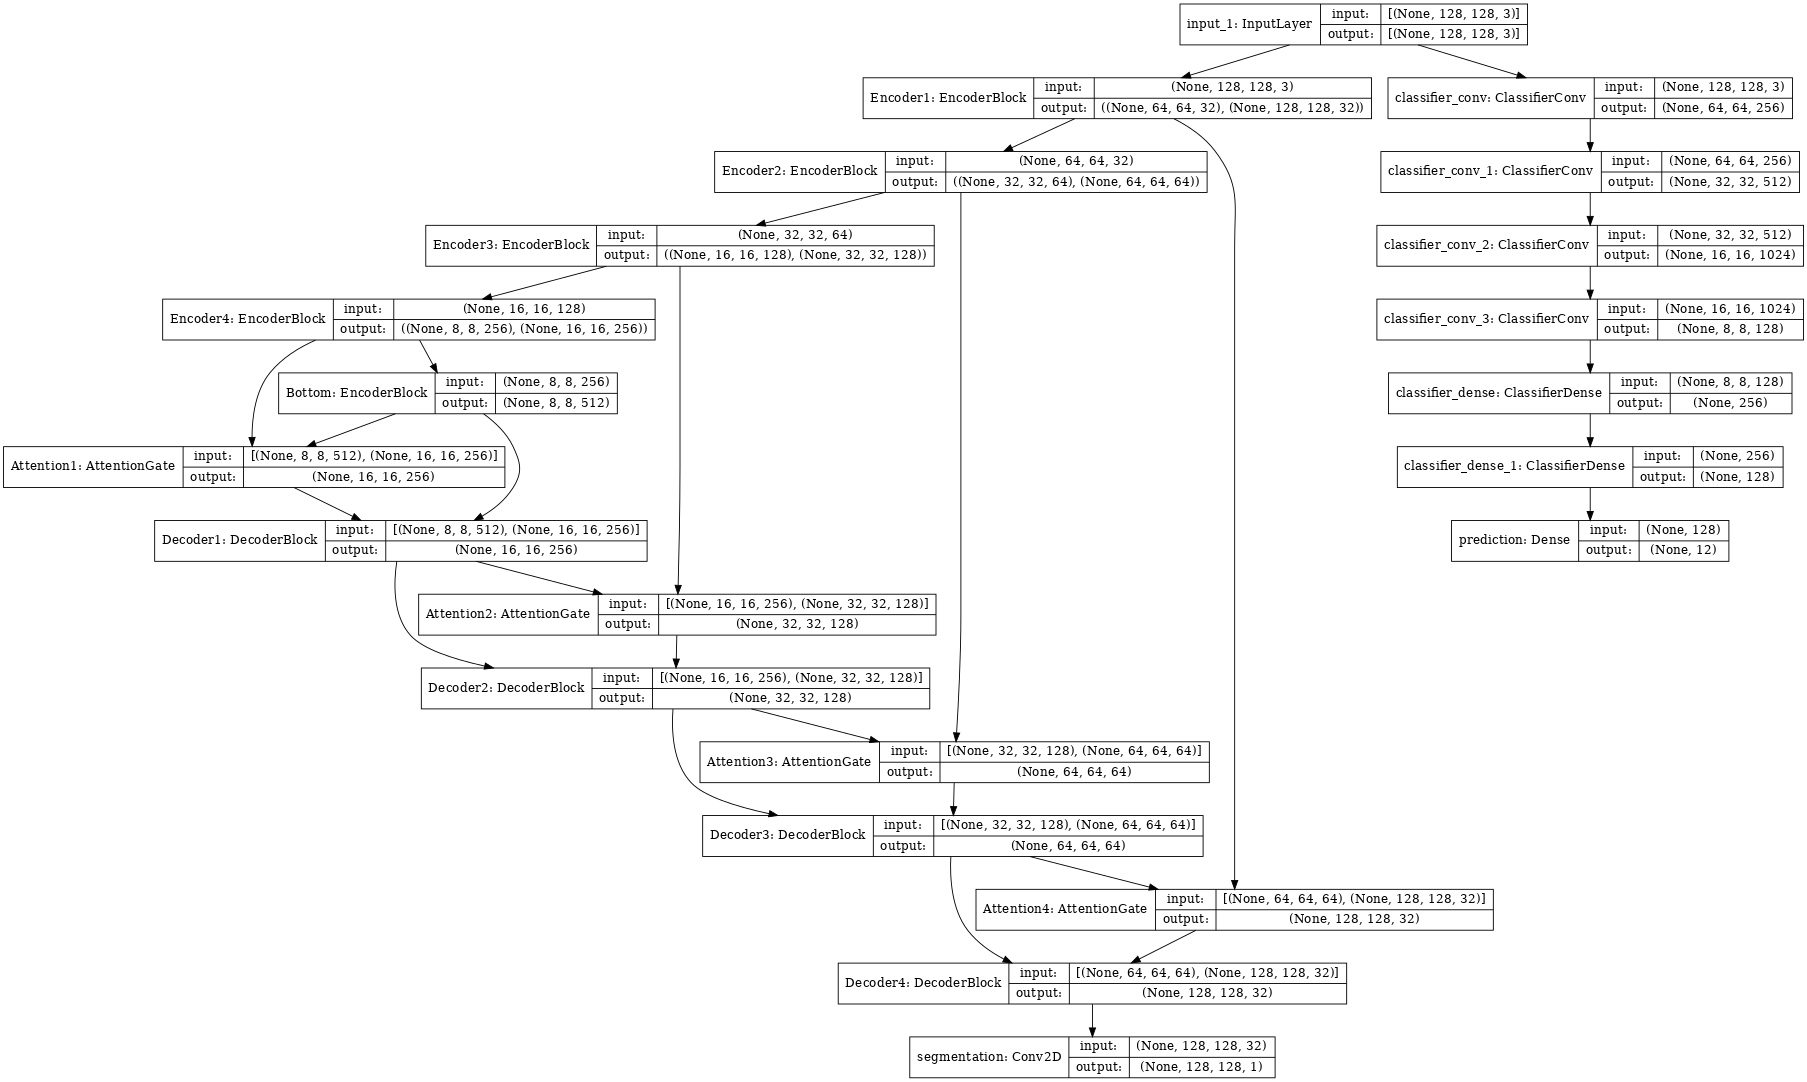

In [26]:
# Inputs
input_layer = Input(shape=images.shape[-3:])

# Encoder
p1, c1 = EncoderBlock(32,0.1, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64,0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128,0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256,0.2, name="Encoder4")(p3)

# Encoding
encoding = EncoderBlock(512,0.3, pooling=False, name="Bottom")(p4)

# Attention + Decoder
a1 = AttentionGate(256, bn=True, name="Attention1")([encoding, c4])
d1 = DecoderBlock(256,0.2, name="Decoder1")([encoding, a1])

a2 = AttentionGate(128, bn=True, name="Attention2")([d1, c3])
d2 = DecoderBlock(128,0.2, name="Decoder2")([d1, a2])

a3 = AttentionGate(64, bn=True, name="Attention3")([d2, c2])
d3 = DecoderBlock(64,0.1, name="Decoder3")([d2, a3])

a4 = AttentionGate(32, bn=True, name="Attention4")([d3, c1])
d4 = DecoderBlock(32,0.1, name="Decoder4")([d3, a4])

# Output 

# x= Flatten()(encoding)
# x= Dense(1024, activation='relu')(x)
# x= Dense(512, activation='relu')(x)
# x= Dense(64, activation='relu')(x)


x = ClassifierConv(128)(input_layer)
x = ClassifierConv(256)(x)
x = ClassifierConv(512)(x)
x = ClassifierConv(64)(x)
x = ClassifierDense(512)(x)
x = ClassifierDense(256)(x)

output_layer_2= Dense(len(labels_name), activation='softmax', name="prediction")(x)


output_layer = Conv2D(1, kernel_size=1, activation='sigmoid', padding='same',name="segmentation")(d4)

# Model
model = Model(
    inputs=[input_layer],
    outputs=[output_layer,output_layer_2]
)

# Compile
model.compile(
    loss={'segmentation':jacard_coef_loss,'prediction':'categorical_crossentropy'},
    optimizer=tf.optimizers.Adam(), 
    metrics={'segmentation':[tversky_loss],'prediction':['accuracy']},
    loss_weights={'segmentation':1,'prediction':5}
)


# Callbacks
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# EarlyStopping(patience=3, restore_best_weight=True),

# model.load_weights("AttentionCustomUNet.h5")
cb = [
    ModelCheckpoint("AttentionCustomUNet.h5", save_best_only=True),
#     ShowProgress(),
    tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
]

# model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64, expand_nested=True)

# **Training**

In [27]:
# Config Training
with tf.device('/device:GPU:0'):
    BATCH_SIZE = 2
    SPE = len(images)//BATCH_SIZE

    # Training
    results = model.fit(
      images, [masks, labels],
      epochs=15,
      steps_per_epoch=SPE,
      batch_size=BATCH_SIZE,
      callbacks=cb
    )

#         # Training
#     results = model.fit(
#       images_train, [masks_train],
#       validation_data=(images_test, [masks_test]),
#       epochs=35,
#       steps_per_epoch=SPE,
#       batch_size=BATCH_SIZE,
#       callbacks=cb
#     )

Epoch 1/15
987/987 [==============================] - 52s 42ms/step - loss: 12.1312 - segmentation_loss: -0.1767 - prediction_loss: 2.4616 - segmentation_tversky_loss: 0.6031 - prediction_accuracy: 0.0750
Epoch 2/15
987/987 [==============================] - 40s 41ms/step - loss: 12.1127 - segmentation_loss: -0.1767 - prediction_loss: 2.4579 - segmentation_tversky_loss: 0.6022 - prediction_accuracy: 0.0866
Epoch 3/15
987/987 [==============================] - 40s 41ms/step - loss: 12.1105 - segmentation_loss: -0.1767 - prediction_loss: 2.4574 - segmentation_tversky_loss: 0.6024 - prediction_accuracy: 0.0795
Epoch 4/15
987/987 [==============================] - 40s 41ms/step - loss: 12.1092 - segmentation_loss: -0.1767 - prediction_loss: 2.4572 - segmentation_tversky_loss: 0.6014 - prediction_accuracy: 0.0871
Epoch 5/15
987/987 [==============================] - 40s 41ms/step - loss: 12.1083 - segmentation_loss: -0.1767 - prediction_loss: 2.4570 - segmentation_tversky_loss: 0.6018 - pre

# **Evaluation**

In [31]:
# loss,segmentation_loss,prediction_loss,segmentation_accuracy,segmentation_IoU,prediction_accuracy,\
# val_loss,val_segmentation_loss,val_prediction_loss,val_segmentation_accuracy,val_segmentation_IoU,val_prediction_accuracy=results.history.values()

In [32]:
# plt.figure(figsize=(20,8))
# plt.style.use("ggplot")

# plt.subplot(2,3,1)
# plt.title("Loss")
# plt.plot(loss, label="Training")
# plt.plot(val_loss, label="Validation")
# plt.legend()
# plt.grid()

# plt.subplot(2,3,2)
# plt.title("Segmentation Loss")
# plt.plot(segmentation_loss, label="Training")
# plt.plot(val_segmentation_loss, label="Validation")
# plt.legend()
# plt.grid()

# plt.subplot(2,3,3)
# plt.title("Classification Loss")
# plt.plot(prediction_loss, label="Training")
# plt.plot(val_prediction_loss, label="Validation")
# plt.legend()
# plt.grid()


# plt.subplot(2,3,4)
# plt.title("Model IoU")
# plt.plot(segmentation_IoU, label="Training")
# plt.plot(val_segmentation_IoU, label="Validation")
# plt.legend()
# plt.grid()

# plt.subplot(2,3,5)
# plt.title("Segmentation Accuracy")
# plt.plot(segmentation_accuracy, label="Training")
# plt.plot(val_segmentation_accuracy, label="Validation")
# plt.legend()
# plt.grid()

# plt.subplot(2,3,6)
# plt.title("Classification Accuracy")
# plt.plot(prediction_accuracy, label="Training")
# plt.plot(val_prediction_accuracy, label="Validation")
# plt.legend()
# plt.grid()


# plt.show()

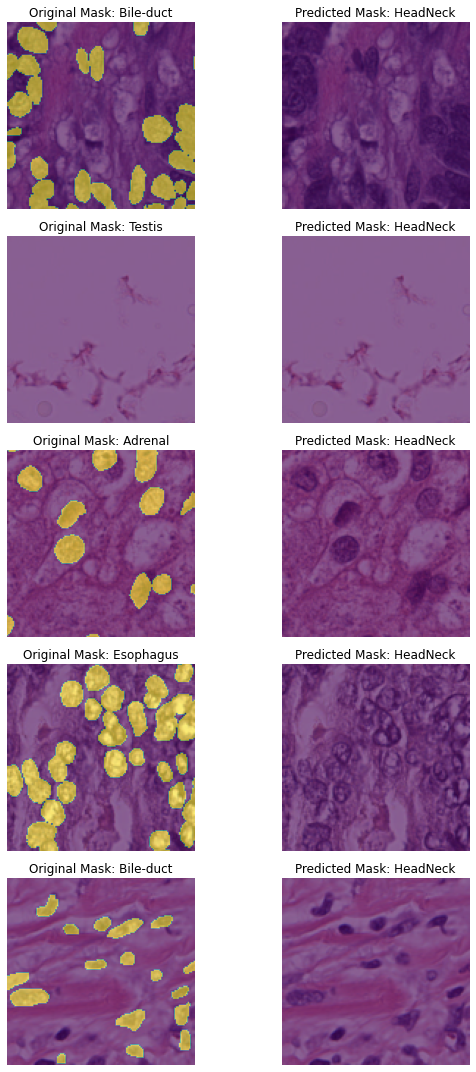

In [33]:
plt.figure(figsize=(9,15))
n=0
for i in range(1,(5*2)+1):
    plt.subplot(5,2,i)
    if n==0:
        id = np.random.randint(len(images))
        image = images[id]
        mask = masks[id]
        pred_mask, class_label= model.predict(image[np.newaxis,...])
        show_mask(image, mask,title="Original Mask: "+labels_name[np.argmax(labels[id])],alpha=0.6)
        n=1
    elif n==1:
        show_mask(image, pred_mask, title="Predicted Mask: "+labels_name[np.argmax(class_label)],alpha=0.6)
        n=0
    elif n==2:
        pred_mask = (pred_mask>0.5).astype('float')
        show_mask(image, pred_mask,title="Processed Mask: "+labels_name[np.argmax(class_label)],alpha=0.6)
        n=0
plt.tight_layout()
plt.show()

In [34]:
model.save("mymodel")